# Kanji Radical Match

Loading data, training, and output.

In [1]:
import utils as u
import torch.nn as nn
import torch
from utils import KanjiFFNN
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
eng_to_rads = dict(list(u.load_eng_to_rads().items()))
eng_tens, rad_tens, eng_vocab, rad_vocab = u.dict_to_tensors(eng_to_rads)

In [3]:
print("Vocabulary size:", len(eng_vocab))
print("Radical vocabulary size:", len(rad_vocab))


Vocabulary size: 12531
Radical vocabulary size: 253


In [4]:
# Print a small sample of our data
print(eng_tens[:5])
print(eng_vocab[:5])
print(rad_tens[:5])
print(rad_vocab[:5])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['"male" principle' '"summer"' '%' "'female' principle" "'kimono' sleeve"]
tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
['ノ' 'ハ' 'マ' 'ユ' 'ヨ']


In [5]:
# Example
print(u.get_tensor_from_word("eight", eng_tens, eng_vocab))

tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [7]:
e2r_model = KanjiFFNN(eng_tens.size(1), rad_tens.size(1))
criterion = nn.BCELoss()
optimizer = optim.Adam(e2r_model.parameters(), lr=1e-3)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [8]:
epochs = 8

e2r_model.train_fit(eng_tens, rad_tens, optimizer, criterion, epochs=epochs, scheduler=lr_scheduler, verbose=True)

Epoch        1 Loss: 2.010141088248929e-06
Epoch        2 Loss: 2.18109562410973e-05
Epoch        3 Loss: 6.914364348631352e-06
Epoch        4 Loss: 1.6785830666776747e-05
Epoch        5 Loss: 1.275197064387612e-05
Epoch        6 Loss: 1.2880936992587522e-05
Epoch        7 Loss: 3.3882611205626745e-06
Epoch        8 Loss: 1.2071687933712383e-06


In [9]:
torch.save(e2r_model, "./models/model_v2.pt")

In [10]:
torch.save(e2r_model.state_dict(), "./models/model_v2_state_dict.pt")

In [11]:
loaded_model = KanjiFFNN(eng_tens.size(1), rad_tens.size(1))
loaded_model.load_state_dict(torch.load("./models/model_v2_state_dict.pt"))
loaded_model.eval()

KanjiFFNN(
  (input): Linear(in_features=12531, out_features=253, bias=True)
  (hid1): Linear(in_features=253, out_features=300, bias=True)
  (output): Linear(in_features=300, out_features=253, bias=True)
)

In [12]:
input_word = "eight"
test_tensor = u.get_tensor_from_word(input_word, eng_tens, eng_vocab)
res = loaded_model(test_tensor)
print(res)

tensor([4.3705e-02, 3.9345e-01, 9.1977e-06, 9.2150e-04, 1.5960e-02, 2.0304e-02,
        2.6551e-03, 1.0213e-02, 4.5009e-02, 1.3245e-05, 8.2584e-07, 3.3370e-03,
        4.3560e-03, 1.8998e-04, 1.5283e-05, 4.1099e-08, 2.6898e-02, 1.1968e-01,
        2.6496e-05, 7.6935e-04, 9.6092e-02, 5.2774e-05, 2.0740e-01, 3.8948e-01,
        1.3081e-03, 8.9509e-05, 6.1031e-05, 3.4341e-02, 7.1659e-06, 1.8691e-01,
        7.8907e-03, 1.3916e-03, 2.4811e-02, 1.3278e-01, 1.4392e-02, 1.5153e-05,
        4.4338e-02, 1.1300e-01, 5.2790e-04, 6.0203e-02, 6.5909e-02, 1.1122e-02,
        1.7078e-01, 4.8732e-03, 6.6875e-03, 1.6846e-02, 1.7531e-01, 8.7856e-02,
        3.9110e-06, 2.4138e-01, 2.3942e-04, 3.0816e-02, 2.2000e-01, 4.3880e-02,
        4.5351e-02, 6.2367e-03, 3.5806e-01, 4.2673e-05, 2.5897e-02, 2.0417e-03,
        1.7192e-01, 1.1294e-01, 1.0928e-03, 5.7019e-02, 2.7337e-05, 2.2545e-06,
        4.3534e-04, 7.1227e-04, 2.9846e-04, 3.0512e-02, 8.0987e-07, 2.7414e-04,
        8.0060e-05, 6.2681e-03, 2.1493e-

In [13]:
output_probs = res.detach().numpy().squeeze()
radical_probs = [(radical, prob) for radical, prob in zip(rad_vocab, output_probs)]
sorted_radical_probs = sorted(radical_probs, key=lambda x: x[1], reverse=True)
print(sorted_radical_probs[:15])

[('田', 0.42202067), ('ハ', 0.39345303), ('儿', 0.38947755), ('大', 0.35805595), ('艾', 0.3093144), ('隹', 0.24700668), ('口', 0.2413764), ('目', 0.23185304), ('土', 0.21999907), ('人', 0.20739807), ('日', 0.18727821), ('冖', 0.18691318), ('厶', 0.17530999), ('宀', 0.17191721), ('十', 0.17078212)]


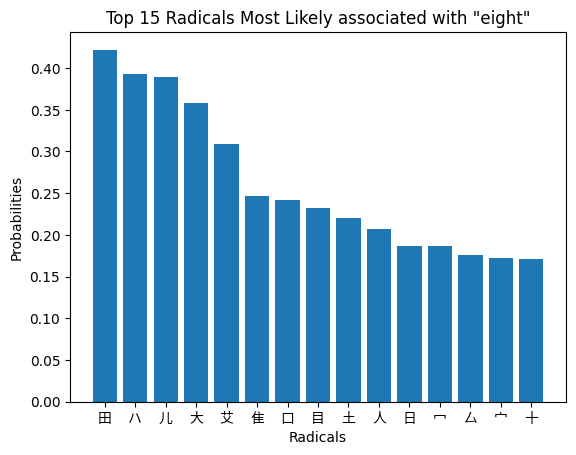

In [14]:
TOP_TAKE = 15
fprop = fm.FontProperties(fname='NotoSansCJKtc-Regular.otf')

radicals, probabilities = zip(*sorted_radical_probs)

radicals_top = list(radicals[:TOP_TAKE])
probabilities_top = list(probabilities[:TOP_TAKE])

fig, axs = plt.subplots()
axs.bar(range(TOP_TAKE), probabilities_top)
axs.set_xticks(range(TOP_TAKE), radicals_top, fontproperties=fprop)
axs.set_xlabel('Radicals')
axs.set_ylabel('Probabilities')
axs.set_title(f'Top {TOP_TAKE} Radicals Most Likely associated with \"{input_word}\"')

plt.show()

In [15]:
with torch.no_grad():
    preds = loaded_model(eng_tens)
    preds = (preds > 0.5)
    print('Precision:', precision_score(rad_tens, preds, average='micro'))
    print('Recall:', recall_score(rad_tens, preds, average='micro'))
    print('F1 Score:', f1_score(rad_tens, preds, average='micro'))
    print('Accuracy:', accuracy_score(rad_tens, preds))

Precision: 0.5816750911766587
Recall: 0.10638596655471429
F1 Score: 0.1798737658534655
Accuracy: 0.04317293113079563
